In [191]:
from collections import deque, namedtuple, OrderedDict
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
import pytorch_lightning as pl

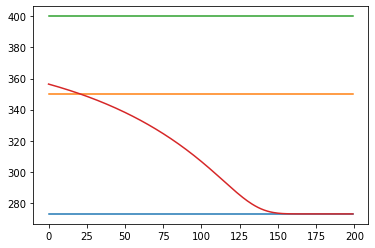

In [211]:
import gym
from gym import spaces

INI_HEAT=273
MAX_HEAT=400
TARGET_TEMP=350
TARGET_INDEX=20
DP=200

#point_heat_init[-1]=1000
def ini_data():
    return np.ones(100)*INI_HEAT

def _transfer(data):
    diff=np.diff(data)
    #point_heat[:-1]+=diff*0.05
    data[1:]-=diff*0.3
    
    data[:]-=(data-INI_HEAT)*0.001
    return data
    
def heat(data):
    data[0]+=(MAX_HEAT-data[0])*0.01
    data = _transfer(data)
    return data

def cool(data):
    data = _transfer(data)
    return data

class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self,):
        super(CustomEnv, self).__init__()    # Define action and observation space
        # They must be gym.spaces objects    # Example when using discrete actions:
        self.action_space = spaces.Discrete(2)    # Example for using image as input:
        self.observation_space = spaces.Box(low=INI_HEAT, high=MAX_HEAT, shape=(DP,1), dtype=np.float)#temp

    def step(self, action):
        self.nstep+=1
        # Execute one time step within the environment
        self.data[:,1:]=self.data[:,:-1]#.copy()
       
        if action==1:
            self.data[:,0]=heat(self.data[:,0])
        elif action==0:
            self.data[:,0]=cool(self.data[:,0])
        else:
            raise Exception(action)
            
            
        obs = self.data[TARGET_INDEX,:].copy()
        reward = -np.abs(TARGET_TEMP-self.data[TARGET_INDEX,:]).mean()
        done=self.nstep>DP*10
        if done:
            self.render()
        return obs, reward, done, {}
        
    
    def reset(self):
        
        self.nstep=0
        # Reset the state of the environment to an initial state
        self.data=np.tile(ini_data(), DP).reshape(-1,DP)
        return self.data[TARGET_INDEX,:]
        

    def render(self, mode='human', close=False):
        #clear_output(wait=True)
        plt.plot(np.ones_like(self.data[TARGET_INDEX,:])*INI_HEAT)
        plt.plot(np.ones_like(self.data[TARGET_INDEX,:])*TARGET_TEMP)
        plt.plot(np.ones_like(self.data[TARGET_INDEX,:])*MAX_HEAT)
        plt.plot(self.data[TARGET_INDEX,:])
        plt.show()
        plt.close()

from IPython.core.display import clear_output
import matplotlib.pyplot as plt
env=CustomEnv()
env.reset()
for i in range(DP):
    env.step(1)
env.render()
    

In [212]:
class DQN(nn.Module):
    """
    Simple MLP network
    >>> DQN(10, 5)  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    DQN(
      (net): Sequential(...)
    )
    """

    def __init__(self, obs_size: int, n_actions: int, hidden_size: int = 128):
        """
        Args:
            obs_size: observation/state size of the environment
            n_actions: number of discrete actions available in the environment
            hidden_size: size of hidden layers
        """
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        #print(x)
        return self.net(x.float())


# Named tuple for storing experience steps gathered in training
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])


class ReplayBuffer:
    """
    Replay Buffer for storing past experiences allowing the agent to learn from them
    >>> ReplayBuffer(5)  # doctest: +ELLIPSIS
    <...reinforce_learn_Qnet.ReplayBuffer object at ...>
    """

    def __init__(self, capacity: int) -> None:
        """
        Args:
            capacity: size of the buffer
        """
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> int:
        return len(self.buffer)

    def append(self, experience: Experience) -> None:
        """
        Add experience to the buffer
        Args:
            experience: tuple (state, action, reward, done, new_state)
        """
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        #print(np.array(indices).shape)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool),
            np.array(next_states),
        )

class Agent:
    """
    Base Agent class handling the interaction with the environment
    >>> env = gym.make("CartPole-v0")
    >>> buffer = ReplayBuffer(10)
    >>> Agent(env, buffer)  # doctest: +ELLIPSIS
    <...reinforce_learn_Qnet.Agent object at ...>
    """

    def __init__(self, env: gym.Env, replay_buffer: ReplayBuffer) -> None:
        """
        Args:
            env: training environment
            replay_buffer: replay buffer storing experiences
        """
        self.env = env
        self.replay_buffer = replay_buffer
        self.reset()
        self.state = self.env.reset()

    def reset(self) -> None:
        """Resets the environment and updates the state"""
        self.state = self.env.reset()

    def get_action(self, net: nn.Module, epsilon: float, device: str) -> int:
        """
        Using the given network, decide what action to carry out
        using an epsilon-greedy policy
        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device
        Returns:
            action
        """
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor([self.state])

            if device not in ['cpu']:
                state = state.cuda(device)

            q_values = net(state)
            _, action = torch.max(q_values, dim=1)
            action = int(action.item())

        return action

    @torch.no_grad()
    def play_step(self, net: nn.Module, epsilon: float = 0.0, device: str = 'cpu') -> Tuple[float, bool]:
        """
        Carries out a single interaction step between the agent and the environment
        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device
        Returns:
            reward, done
        """

        action = self.get_action(net, epsilon, device)

        # do step in the environment
       # print(action)
        new_state, reward, done, _ = self.env.step(action)

        exp = Experience(self.state, action, reward, done, new_state)

        self.replay_buffer.append(exp)

        self.state = new_state
        if done:
            self.reset()
        return reward, done
    
class RLDataset(IterableDataset):
    """
    Iterable Dataset containing the ExperienceBuffer
    which will be updated with new experiences during training
    >>> RLDataset(ReplayBuffer(5))  # doctest: +ELLIPSIS
    <...reinforce_learn_Qnet.RLDataset object at ...>
    """

    def __init__(self, buffer: ReplayBuffer, sample_size: int = 200) -> None:
        """
        Args:
            buffer: replay buffer
            sample_size: number of experiences to sample at a time
        """
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self) -> Tuple:
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

In [213]:
class DQNLightning(pl.LightningModule):
    """ Basic DQN Model
    >>> DQNLightning(env="CartPole-v0")  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    DQNLightning(
      (net): DQN(
        (net): Sequential(...)
      )
      (target_net): DQN(
        (net): Sequential(...)
      )
    )
    """

    def __init__(
        self,
        env, #environment
        replay_size: int = 1000, #capacity of the replay buffer
        warm_start_steps: int = 1000, #how many samples do we use to fill our buffer at the start of training
        gamma: float = 0.99, #discount factor
        eps_start: float = 1.0, #starting value of epsilon
        eps_end: float = 0.01, #final value of epsilon
        eps_last_frame: int = 200, #what frame should epsilon stop decaying
        sync_rate: int = 10, #how many frames do we update the target network
        lr: float = 1e-2, #learning rate
        episode_length: int = 50, #max length of an episode
        batch_size: int = 2, #size of the batches
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        self.replay_size = replay_size
        self.warm_start_steps = warm_start_steps
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_last_frame = eps_last_frame
        self.sync_rate = sync_rate
        self.lr = lr
        self.episode_length = episode_length
        self.batch_size = batch_size

        self.env = env
        obs_size = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n
        
        
        self.net = DQN(obs_size, n_actions)
        self.target_net = DQN(obs_size, n_actions)

        self.buffer = ReplayBuffer(self.replay_size)
        self.agent = Agent(self.env, self.buffer)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.warm_start_steps)

    def populate(self, steps: int = 1000) -> None:
        """
        Carries out several random steps through the environment to initially fill
        up the replay buffer with experiences
        Args:
            steps: number of random steps to populate the buffer with
        """
        for i in range(steps):
            self.agent.play_step(self.net, epsilon=1.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Passes in a state `x` through the network and gets the `q_values` of each action as an output
        Args:
            x: environment state
        Returns:
            q values
        """
        output = self.net(x)
        return output

    def dqn_mse_loss(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Calculates the mse loss using a mini batch from the replay buffer
        Args:
            batch: current mini batch of replay data
        Returns:
            loss
        """
        states, actions, rewards, dones, next_states = batch
       #print(states)
        #print( self.net(states),actions.unsqueeze(-1))
        state_action_values = self.net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.target_net(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * self.gamma + rewards

        return nn.MSELoss()(state_action_values, expected_state_action_values)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], nb_batch) -> OrderedDict:
        """
        Carries out a single step through the environment to update the replay buffer.
        Then calculates loss based on the minibatch received
        Args:
            batch: current mini batch of replay data
            nb_batch: batch number
        Returns:
            Training loss and log metrics
        """
        device = self.get_device(batch)
        epsilon = max(self.eps_end, self.eps_start - self.global_step + 1 / self.eps_last_frame)

        # step through environment with agent
        reward, done = self.agent.play_step(self.net, epsilon, device)
        self.episode_reward += reward

        # calculates training loss
        #print(batch)
        loss = self.dqn_mse_loss(batch)

        if done:
            self.total_reward = self.episode_reward
            self.episode_reward = 0

        # Soft update of target network
        if self.global_step % self.sync_rate == 0:
            self.target_net.load_state_dict(self.net.state_dict())

        log = {
            'total_reward': torch.tensor(self.total_reward).to(device),
            'reward': torch.tensor(reward).to(device),
            'steps': torch.tensor(self.global_step).to(device)
        }

        return OrderedDict({'loss': loss, 'log': log, 'progress_bar': log})

    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer"""
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        return [optimizer]

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences"""
        dataset = RLDataset(self.buffer, self.episode_length)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.batch_size,
            sampler=None,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader"""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch"""
        return batch[0].device.index if self.on_gpu else 'cpu'


    

In [214]:
model = DQNLightning(CustomEnv())
#model.buffer.sample(1)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name       | Type | Params
------------------------------------
0 | net        | DQN  | 26.0 K
1 | target_net | DQN  | 26.0 K
------------------------------------
52.0 K    Trainable params
0         Non-trainable params
52.0 K    Total params
0.208     Total estimated model params size (MB)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


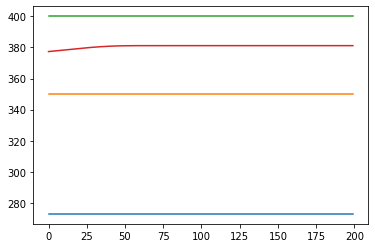

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


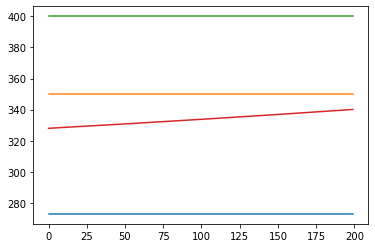

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


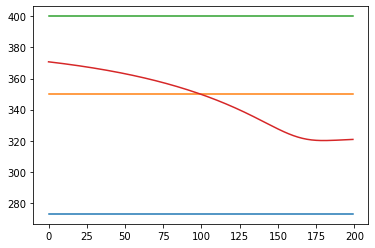

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


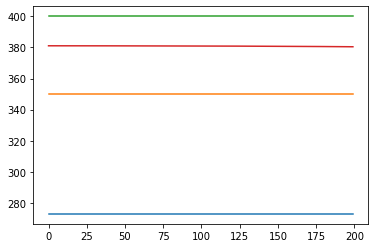

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


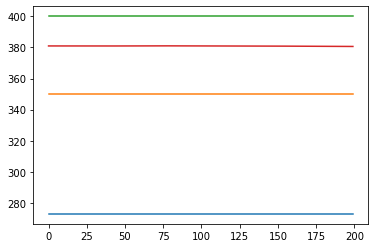

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


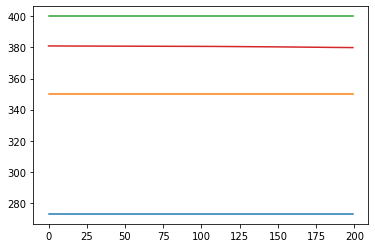

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


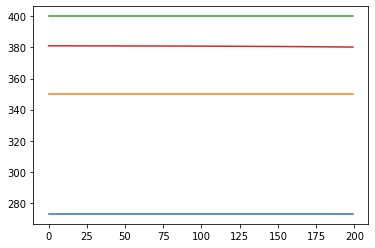

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


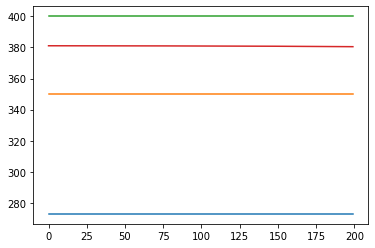

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


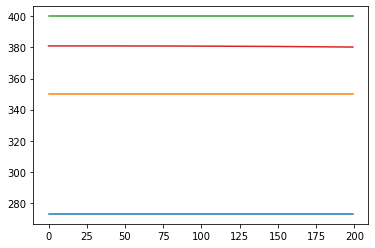

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


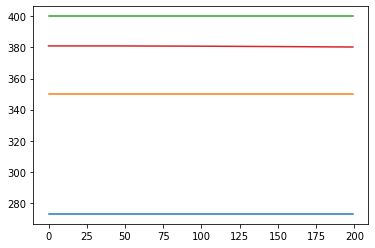

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


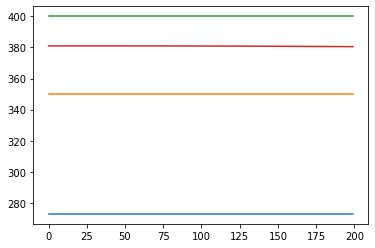

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


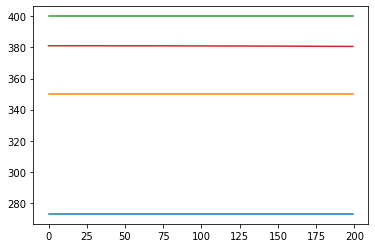

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [215]:
trainer = pl.Trainer(
    gpus=1,
    accelerator='dp',
    val_check_interval=100,
)

trainer.fit(model)